Netket implementation

In [1]:
import os
os.environ["NUMBA_NUM_THREADS"] = "20"

import netket as nk
import netket.experimental as nkx
import netket.nn as nknn
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc

from math import pi
import numpy as np
from vmc_torch.fermion_utils import generate_random_fmps
import quimb.tensor as qtn
import symmray as sr

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sijingdu/TNVMC/VMC_code/quimb/quimb/core.py:45: UserWarning: 'NUMBA_NUM_THREADS' has been set elsewhere and doesn't match the value 'quimb' has tried to set - 20 vs 10.
  warnings.warn(
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [3]:
# Define the number of nodes
L = 8  # Replace with your desired number of nodes
spinless = False
cyclic = False
seed = 1
np.random.seed(seed)
# Generate all possible edges for a fully connected graph
edges = [(i, j) for i in range(L) for j in range(i + 1, L)]
# edges = qtn.edges_1d_chain(L, cyclic=cyclic)

# Create the fully connected graph
graph = nk.graph.Graph(edges=edges)
N = graph.n_nodes
# Display information about the graph
print(f"Number of nodes: {graph.n_nodes}")
print(f"Number of edges: {graph.n_edges}")

# Define the fermion filling and the Hilbert space
N_f = int(L)
n_fermions_per_spin = (N_f//2, N_f//2)
hi = nkx.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions_per_spin=n_fermions_per_spin)

# Define the random hopping fully connected Hubbard model Hamiltonian
U = 8.0
t_mean = 0.0
t_std = 1.0
mu = 0.0
# Generate edge-hopping dictionary
edge_to_hopping = {}
for (i,j) in graph.edges():
    t = np.random.normal(t_mean, t_std)
    edge_to_hopping[(i,j)] = t

H = 0.0
for (i,j) in graph.edges():
    t = edge_to_hopping[(i,j)]
    for spin in (1,-1):
        H -= t * (cdag(hi,i,spin) * c(hi,j,spin) + cdag(hi,j,spin) * c(hi,i,spin))
for i in graph.nodes():
    H += U * nc(hi,i,+1) * nc(hi,i,-1)

# Exact diagonalization of the Hamiltonian for benchmark
sp_h = H.to_sparse() # Convert the Hamiltonian to a sparse matrix
from scipy.sparse.linalg import eigsh
eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
E_gs = eig_vals[0]
print("Exact ground state energy per site:", E_gs/N)
print("Exact ground state energy:", E_gs)

Number of nodes: 8
Number of edges: 28
Exact ground state energy per site: -0.8322748849140347
Exact ground state energy: -6.658199079312277


fMPS_backflow_attn (D=4, chi=-1) sample size: 15000, energy: [-0.7969334639864334, -0.7964526421862047], error: [0.0009656707938796718, 0.0009129294053665336]
Relative errors: 0.04246363980003035, 0.0430413597444191
fMPS_backflow_attn (D=6, chi=-1) sample size: 12000, energy: [-0.8164705274057261, -0.8152554884871868], error: [0.0009408624228442326, 0.0006980232760985125]
Relative errors: 0.018989348104551995, 0.020449249082658355


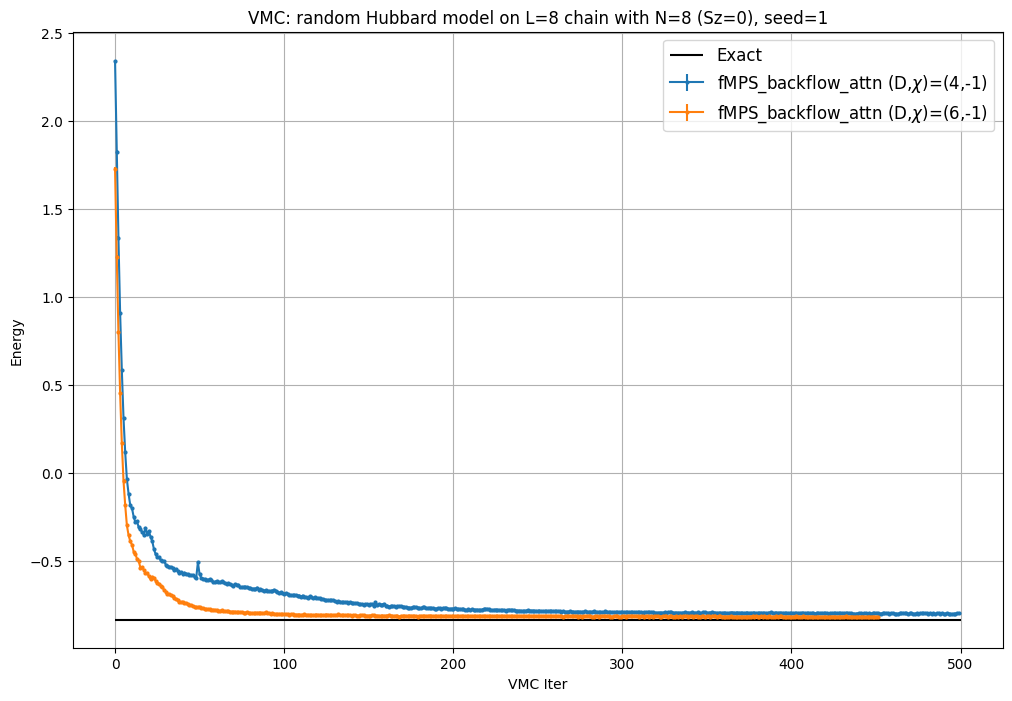

In [16]:
import json
import matplotlib.pyplot as plt
import glob

# Function to read data from JSON file
def read_data_from_json(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)
    return data
t=1.0
U=8.0
symmetry='Z2'
L=8
N=L

model_name_list = ['fMPS', 'fMPS_backflow_attn','fMPS_TNF']
legend_dict = {'fMPS':'fMPS', 'fMPS_backflow_attn': 'fMPS_backflow_attn', 'fMPS_TNF': 'fMPS_TNF'}
color_list = ['blue', 'purple', 'orange', 'brown', 'pink']
color_map = dict(zip(model_name_list, color_list))
D_chi_dict = {
    'fMPS': [(4,-1), (8,-1)],
    'fMPS_backflow_attn': [(4,-1), (6,-1)],
    'fMPS_TNF': [],
}
scale = 1/L
# scale = 1

fig, ax = plt.subplots(figsize=(12, 8))
pwd = '/home/sijingdu/TNVMC/VMC_code/vmc_torch/data'
for model_name in model_name_list:
    D_chi_list = D_chi_dict[model_name]
    for D_calc, chi in D_chi_list:
        # Path pattern to the JSON files (using glob to match multiple files)
        file_pattern = pwd+f'/L={L}/random_t_U=8.0/seed{seed}/N={N}/{symmetry}/D={D_calc}/{model_name}/chi={chi}/energy_stats_start_*.json'
        # Collecting all files that match the pattern
        file_list = glob.glob(file_pattern)
        # Sort the file list according to the iteration number
        file_list.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
        # Initialize lists to concatenate data
        concatenated_means = []
        concatenated_errors = []
        concatenated_steps = []
        
        for file_name in file_list:  # Sorting files to keep steps in order
            # Read data from the JSON file
            try:
                data = read_data_from_json(file_name)
            except:
                continue
            
            sample_size = data.get("sample size:", None)

            # Extracting and normalizing means and errors
            means_ftnn_nn = data["mean"]

            means_ftnn_nn = [mean * scale for mean in means_ftnn_nn]  # Normalize the energy
            errors_ftn_nn = data["error"]
            errors_ftn_nn = [error * scale for error in errors_ftn_nn]  # Normalize the error
            steps_ftn_nn = list(range(len(concatenated_means), len(concatenated_means) + len(means_ftnn_nn)))

            # Concatenating data
            concatenated_means.extend(means_ftnn_nn)
            concatenated_errors.extend(errors_ftn_nn)
            concatenated_steps.extend(steps_ftn_nn)
        
        # chi = r'$\infty$' if chi == -1 or chi==-2 else chi
        
        # Plotting the concatenated data with error bars
        if concatenated_means:  # Ensure there is data to plot
            ax.errorbar(concatenated_steps, concatenated_means, yerr=concatenated_errors, fmt='s-' if model_name == 'fMPS' else '.-',  
                        label=r'{} (D,$\chi$)=({},{})'.format(legend_dict[model_name], D_calc, chi), linewidth=1.5, markersize=4)
            print(f'{model_name} (D={D_calc}, chi={chi}) sample size: {sample_size}, energy: {concatenated_means[-2:]}, error: {concatenated_errors[-2:]}')
            print(f'Relative errors: {abs(concatenated_means[-2]-E_gs/N)/abs(E_gs/N)}, {abs(concatenated_means[-1]-E_gs/N)/abs(E_gs/N)}')


# ax.set_ylim(-0.35,-0.1)
# ax.hlines([-0.29468312587688006], xmin=0, xmax=200, color='black', label="Exact")
ax.hlines([E_gs/N], xmin=0, xmax=500, color='black', label="Exact")
ax.set_xlabel('VMC Iter')
ax.set_ylabel('Energy')
# ax.legend(loc='upper right', fontsize=12)
ax.legend(fontsize=12)

plt.title(r'VMC: random Hubbard model on L={} chain with N={} (Sz=0), seed={}'.format(L, N, seed))
plt.grid(True)
plt.show()

In [57]:
# fMPS spinful
D = 4
symmetry = 'U1'
seed = 2
# SU in quimb
fmps, charge_config = generate_random_fmps(L, D, seed, symmetry, Nf=N_f, cyclic=cyclic, spinless=spinless)
try:
    parse_edges_to_site_info = sr.utils.parse_edges_to_site_info
except AttributeError:
    parse_edges_to_site_info = sr.parse_edges_to_site_info

site_info = parse_edges_to_site_info(
    edges,
    D,
    phys_dim=2 if spinless else 4,
    site_ind_id="k{}",
    site_tag_id="I{}",
)

terms = {
    (sitea, siteb): sr.fermi_hubbard_local_array(
        t=t, U=U, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    )
    for (sitea, siteb), t in edge_to_hopping.items()
}

ham = qtn.LocalHam1D(L=L, H2=terms, cyclic=cyclic)
su = qtn.SimpleUpdateGen(fmps, ham, compute_energy_per_site=True, D=D, gate_opts={'cutoff':1e-12})

# # cluster energies may not be accuracte yet
# su.evolve(50, tau=0.3)
# su.evolve(50, tau=0.1)


In [47]:
ham.get_gate_expm((0, 1), 0.1)

U1FermionicArray(shape~(16, 16):[+-], charge=0, num_blocks=5)

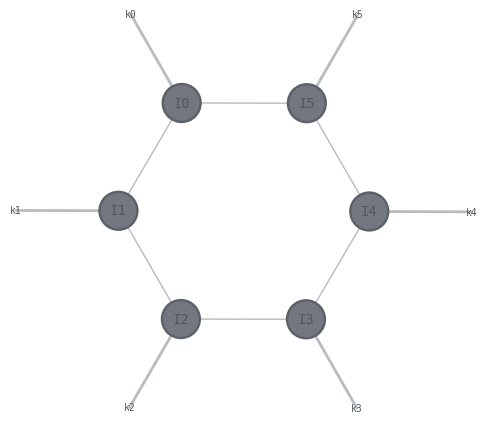

In [ ]:
chain_edges = qtn.edges_1d_chain(L, cyclic=cyclic)
test_fmps = sr.TN_abelian_from_edges_rand(symmetry, edges=chain_edges, bond_dim=D, phys_dim=2 if spinless else 4)
sr.ham_fermi_hubbard_from_edges